# EstrelaBet - Exploratory Data Analysis

## Objective
Develop a predictive model to predict **customer churn** (whether a customer will NOT make a redeposit after their first bet).

## Target Variable
- **Churn = 1**: Customer did NOT make a redeposit (churned)
- **Churn = 0**: Customer made a redeposit (retained)

## Dataset Overview
- **10,000 sessions** from **1,446 users**
- **29 variables** covering behavioral, financial, and demographic data
- **Period**: July 2023 - December 2024

---

## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr

# Survival analysis
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    LIFELINES_AVAILABLE = True
except ImportError:
    LIFELINES_AVAILABLE = False
    print("lifelines not installed. Run: pip install lifelines")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the dataset
df = pd.read_csv('../data/test_dataset.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset Shape: {df.shape}")
print(f"Total Sessions: {len(df):,}")
print(f"Unique Users: {df['user_id'].nunique():,}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

Dataset Shape: (10000, 29)
Total Sessions: 10,000
Unique Users: 1,446
Date Range: 2023-07-29 00:00:00 to 2024-12-31 00:00:00


In [3]:
# First look at the data
df.head()

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
0,user_001948,sess_00000068,2023-07-29 23:55:21.913140+00:00,2023-07-29,23,5,1,0,roulette,NaN,BR,mobile,bank_transfer,44.00,2,bronze,welcome_bonus,65.28,171.71,106.43,59,19,0,NaN,NaN,NaN,0.00,19,65.28
1,user_001628,sess_00000730,2023-08-01 01:46:56.989818+00:00,2023-08-01,1,1,0,0,live_dealer,NaN,DE,mobile,debit_card,NaN,5,bronze,free_spins,14.04,0.00,-14.04,57,19,0,NaN,NaN,NaN,0.00,19,14.04
2,user_001559,sess_00000311,2023-08-01 14:30:03.483604+00:00,2023-08-01,14,1,0,0,roulette,NaN,AU,desktop,crypto,NaN,6,bronze,none,14.63,21.90,7.27,113,37,0,NaN,NaN,NaN,0.00,37,14.63
3,user_000376,sess_00001978,2023-08-03 04:32:38.914782+00:00,2023-08-03,4,3,0,0,poker,NaN,UK,mobile,credit_card,35.00,4,bronze,none,13.15,30.61,17.46,63,21,0,NaN,NaN,NaN,0.00,21,13.15
4,user_000371,sess_00002519,2023-08-04 09:02:22.508701+00:00,2023-08-04,9,4,0,0,casino_slots,NaN,FR,tablet,e_wallet,45.00,1,bronze,welcome_bonus,115.25,0.00,-115.25,38,12,1,NaN,NaN,NaN,0.00,12,115.25


In [4]:
df.head().T

,0,1,2,3,4
user_id,user_001948,user_001628,user_001559,user_000376,user_000371
session_id,sess_00000068,sess_00000730,sess_00000311,sess_00001978,sess_00002519
timestamp,2023-07-29 23:55:21.913140+00:00,2023-08-01 01:46:56.989818+00:00,2023-08-01 14:30:03.483604+00:00,2023-08-03 04:32:38.914782+00:00,2023-08-04 09:02:22.508701+00:00
date,2023-07-29 00:00:00,2023-08-01 00:00:00,2023-08-01 00:00:00,2023-08-03 00:00:00,2023-08-04 00:00:00
hour,23,1,14,4,9
day_of_week,5,1,1,3,4
is_weekend,1,0,0,0,0
is_holiday,0,0,0,0,0
game_type,roulette,live_dealer,roulette,poker,casino_slots
sport_type,NaN,NaN,NaN,NaN,NaN


In [5]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   user_id                     10000 non-null  object             
 1   session_id                  10000 non-null  object             
 2   timestamp                   10000 non-null  datetime64[ns, UTC]
 3   date                        10000 non-null  datetime64[ns]     
 4   hour                        10000 non-null  int64              
 5   day_of_week                 10000 non-null  int64              
 6   is_weekend                  10000 non-null  int64              
 7   is_holiday                  10000 non-null  int64              
 8   game_type                   9798 non-null   object             
 9   sport_type                  1567 non-null   object             
 10  country                     9905 non-null   object         

---
## 2. Data Quality Assessment

In [6]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum() / len(df) * 100).values,
    'Data Type': df.dtypes.values
}).sort_values('Missing %', ascending=False)

missing_df[missing_df['Missing %'] > 0]

,Column,Missing Count,Missing %,Data Type
24,withdrawal_amount,9198,91.98,float64
9,sport_type,8433,84.33,object
23,deposit_amount,7237,72.37,float64
25,previous_session_gap_hours,1446,14.46,float64
13,user_age,765,7.65,float64
28,avg_bet_size,438,4.38,float64
12,payment_method,282,2.82,object
15,vip_tier,278,2.78,object
8,game_type,202,2.02,object
10,country,95,0.95,object


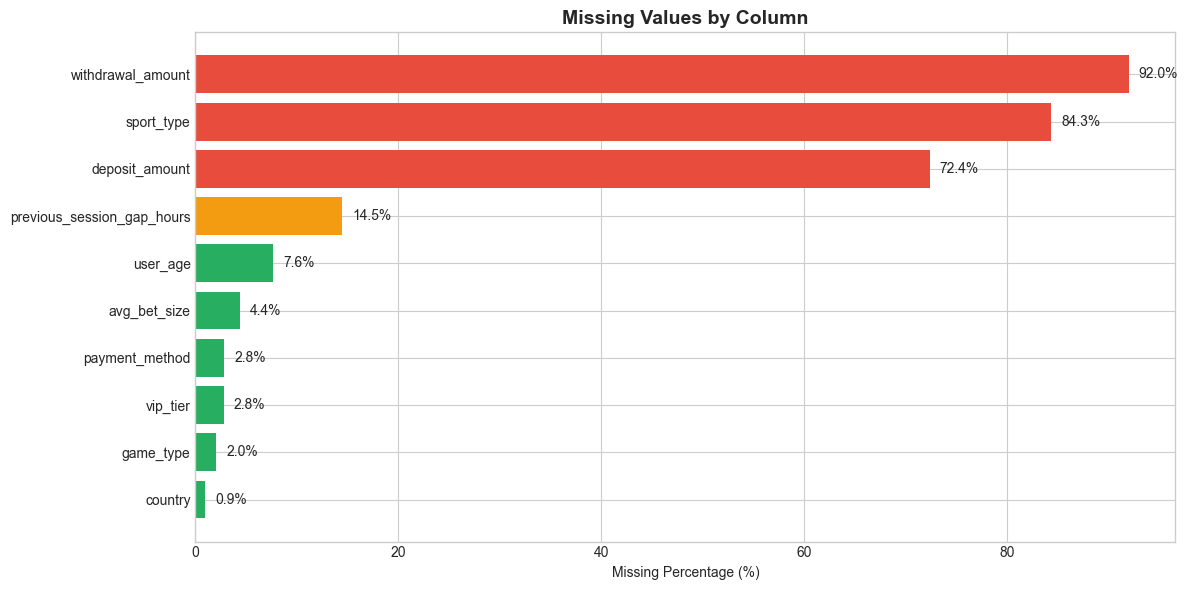

In [7]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 6))

missing_cols = missing_df[missing_df['Missing %'] > 0].sort_values('Missing %', ascending=True)
colors = ['#e74c3c' if x > 50 else '#f39c12' if x > 10 else '#27ae60' for x in missing_cols['Missing %']]

bars = ax.barh(missing_cols['Column'], missing_cols['Missing %'], color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')

# Add percentage labels
for bar, pct in zip(bars, missing_cols['Missing %']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Key Observations on Missing Data:
- **sport_type (84%)**: Only populated for sports_betting sessions
- **withdrawal_amount (91%)**: Most sessions don't have withdrawals
- **deposit_amount (72%)**: Not every session involves a deposit
- **user_age (7.65%)**: Some users didn't provide age
- **payment_method (2.8%)**: Minor missing data

---
## 3. Target Variable Construction

In [ ]:
def create_churn_target(df):
    """
    Create target variable: Did user churn (NOT make a redeposit) after their first session?
    
    Target:
        - 1 = Churned (no redeposit after first session)
        - 0 = Retained (made a redeposit after first session)
    
    Returns:
        DataFrame with user-level data and target variable
    """
    # Sort by user and timestamp
    df_sorted = df.sort_values(['user_id', 'timestamp']).copy()
    
    # Mark first session for each user
    df_sorted['is_first_session'] = ~df_sorted.duplicated('user_id', keep='first')
    
    # For each user, check if they churned (NO deposit after first session)
    def check_churn(group):
        # Get sessions after the first one
        subsequent_sessions = group[~group['is_first_session']]
        
        # Check if any subsequent session has a deposit
        if len(subsequent_sessions) == 0:
            return 1  # No subsequent sessions = churned
        
        has_redeposit = (subsequent_sessions['deposit_amount'].fillna(0) > 0).any()
        return 0 if has_redeposit else 1  # 0 = retained, 1 = churned
    
    # Create target
    target = df_sorted.groupby('user_id').apply(check_churn)
    target.name = 'churn'
    
    return target, df_sorted

# Create target variable
target, df_processed = create_churn_target(df)

print("Target Variable Distribution:")
print(target.value_counts())
print(f"\nChurn Rate: {target.mean():.2%}")
print(f"Retention Rate: {1 - target.mean():.2%}")

In [ ]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
colors = ['#27ae60', '#e74c3c']  # Green for retained, red for churned
labels = ['Retained (Churn=0)', 'Churned (Churn=1)']
sizes = [len(target) - target.sum(), target.sum()]  # [retained, churned]

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            startangle=90, explode=(0, 0.05))
axes[0].set_title('Target Distribution (Churn)', fontsize=14, fontweight='bold')

# Bar chart with counts
bars = axes[1].bar(['Retained', 'Churned'], sizes, color=colors)
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Users by Churn Status', fontsize=14, fontweight='bold')

# Add count labels
for bar, count in zip(bars, sizes):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 f'{count:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 4. Descriptive Statistics

In [10]:
# Numerical variables statistics
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
hour,10000.00,11.67,6.90,0.00,6.00,12.00,18.00,23.00
day_of_week,10000.00,3.00,2.01,0.00,1.00,3.00,5.00,6.00
is_weekend,10000.00,0.29,0.45,0.00,0.00,0.00,1.00,1.00
is_holiday,10000.00,0.11,0.31,0.00,0.00,0.00,0.00,1.00
user_age,9235.00,44.85,12.09,18.00,36.00,45.00,53.00,91.00
account_age_days,10000.00,83.95,82.88,0.00,25.00,54.00,117.00,522.00
bet_amount,10000.00,1011.03,18558.17,10.00,25.34,46.20,93.42,872489.59
win_amount,10000.00,745.14,19926.44,0.00,0.00,0.00,70.18,1274474.08
net_result,10000.00,-265.88,15828.97,-740071.64,-54.55,-19.39,30.88,562928.16
session_length_minutes,10000.00,63.99,48.99,5.00,29.00,52.00,85.00,576.00


In [11]:
# Categorical variables overview
categorical_cols = ['game_type', 'sport_type', 'country', 'device_type', 
                    'payment_method', 'vip_tier', 'campaign_type']

for col in categorical_cols:
    print(f"\n{'='*50}")
    print(f"{col.upper()}")
    print(f"{'='*50}")
    print(f"Unique values: {df[col].nunique()}")
    print(f"\nValue counts:")
    print(df[col].value_counts())


GAME_TYPE
Unique values: 6

Value counts:
game_type
live_dealer       1736
poker             1695
blackjack         1691
sports_betting    1614
casino_slots      1537
roulette          1525
Name: count, dtype: int64

SPORT_TYPE
Unique values: 7

Value counts:
sport_type
basketball    244
tennis        231
baseball      230
golf          229
hockey        214
soccer        213
football      206
Name: count, dtype: int64

COUNTRY
Unique values: 10

Value counts:
country
UK    1089
CA    1048
FR    1044
US    1033
MX    1030
BR    1021
ES     967
AU     907
DE     890
IT     876
Name: count, dtype: int64

DEVICE_TYPE
Unique values: 3

Value counts:
device_type
tablet     3367
desktop    3321
mobile     3312
Name: count, dtype: int64

PAYMENT_METHOD
Unique values: 5

Value counts:
payment_method
e_wallet         2041
bank_transfer    2028
credit_card      1995
crypto           1896
debit_card       1758
Name: count, dtype: int64

VIP_TIER
Unique values: 5

Value counts:
vip_tier
bronze   

---
## 5. User-Level Analysis

In [ ]:
# Aggregate data at user level
user_stats = df.groupby('user_id').agg({
    'session_id': 'count',
    'timestamp': ['min', 'max'],
    'bet_amount': ['sum', 'mean', 'max'],
    'win_amount': ['sum', 'mean'],
    'net_result': ['sum', 'mean'],
    'deposit_amount': lambda x: x.fillna(0).sum(),
    'withdrawal_amount': lambda x: x.fillna(0).sum(),
    'session_length_minutes': ['sum', 'mean'],
    'games_played': ['sum', 'mean'],
    'account_age_days': 'last',
    'vip_tier': 'last',
    'country': 'first',
    'device_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

# Flatten column names
user_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                       for col in user_stats.columns]

# Rename for clarity
user_stats.columns = [
    'user_id', 'total_sessions', 'first_session', 'last_session',
    'total_bet', 'avg_bet', 'max_bet', 'total_win', 'avg_win',
    'total_net_result', 'avg_net_result', 'total_deposits', 'total_withdrawals',
    'total_time_played', 'avg_session_length', 'total_games', 'avg_games_per_session',
    'account_age_days', 'vip_tier', 'country', 'primary_device'
]

# Add target variable (churn)
user_stats = user_stats.merge(target.reset_index(), on='user_id')

print(f"User-level dataset: {user_stats.shape}")
user_stats.head()

In [ ]:
# Sessions per user distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(user_stats['total_sessions'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(user_stats['total_sessions'].mean(), color='red', linestyle='--', 
                label=f"Mean: {user_stats['total_sessions'].mean():.1f}")
axes[0].axvline(user_stats['total_sessions'].median(), color='orange', linestyle='--', 
                label=f"Median: {user_stats['total_sessions'].median():.1f}")
axes[0].set_xlabel('Number of Sessions')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Sessions per User Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# Box plot by target (churn)
user_stats.boxplot(column='total_sessions', by='churn', ax=axes[1])
axes[1].set_xlabel('Churn Status (0=Retained, 1=Churned)')
axes[1].set_ylabel('Number of Sessions')
axes[1].set_title('Sessions by Churn Status', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## 6. Temporal Analysis

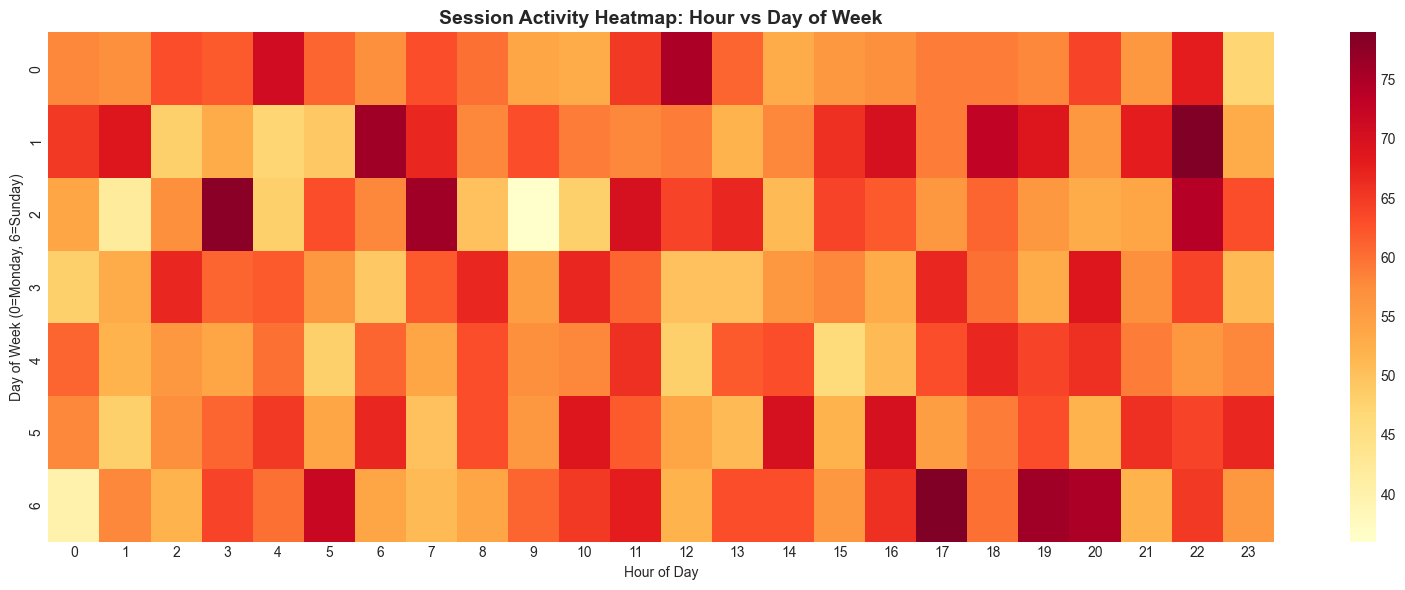

In [14]:
# Activity heatmap: Hour vs Day of Week
activity_matrix = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(activity_matrix, cmap='YlOrRd', annot=False, ax=ax)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week (0=Monday, 6=Sunday)')
ax.set_title('Session Activity Heatmap: Hour vs Day of Week', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

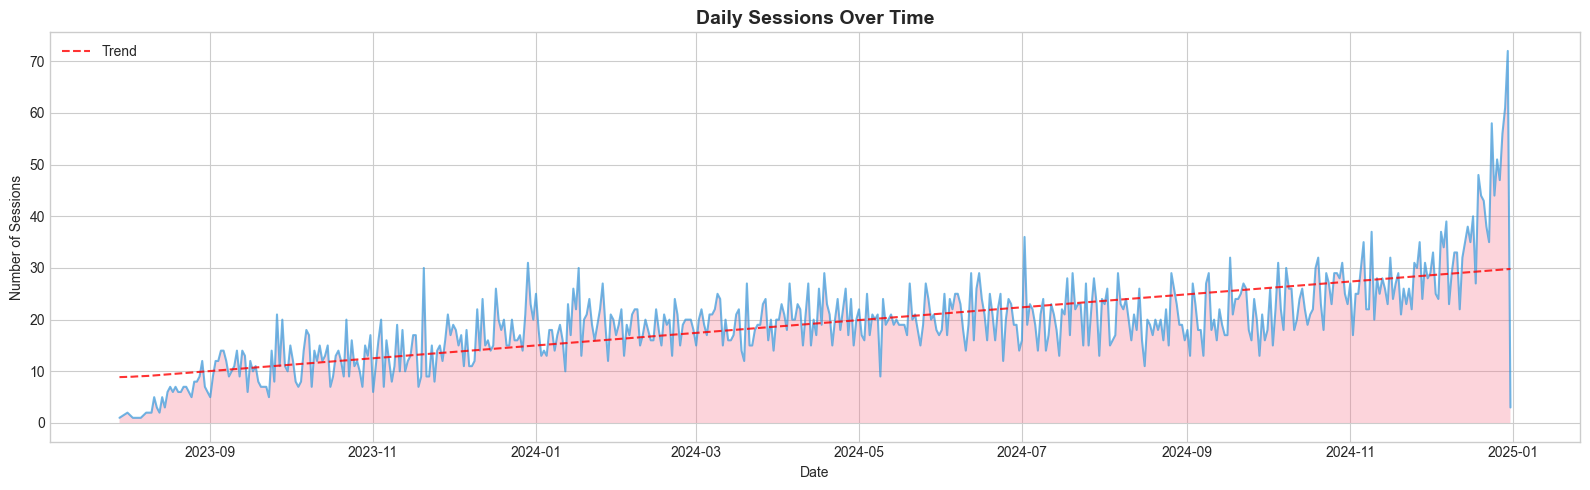

In [15]:
# Sessions over time
daily_sessions = df.groupby('date').size()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(daily_sessions.index, daily_sessions.values, color='#3498db', alpha=0.7)
ax.fill_between(daily_sessions.index, daily_sessions.values, alpha=0.3)

# Add trend line
z = np.polyfit(range(len(daily_sessions)), daily_sessions.values, 1)
p = np.poly1d(z)
ax.plot(daily_sessions.index, p(range(len(daily_sessions))), "r--", alpha=0.8, label='Trend')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Sessions')
ax.set_title('Daily Sessions Over Time', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Weekend vs Weekday analysis
weekend_stats = df.groupby('is_weekend').agg({
    'session_id': 'count',
    'bet_amount': 'mean',
    'session_length_minutes': 'mean',
    'games_played': 'mean'
}).round(2)

weekend_stats.index = ['Weekday', 'Weekend']
weekend_stats.columns = ['Sessions', 'Avg Bet', 'Avg Session Length', 'Avg Games']
weekend_stats

,Sessions,Avg Bet,Avg Session Length,Avg Games
Weekday,7105,736.84,63.69,20.88
Weekend,2895,1683.93,64.72,21.24


---
## 7. Game Type Analysis

In [17]:
# Game type distribution and metrics
game_stats = df.groupby('game_type').agg({
    'session_id': 'count',
    'user_id': 'nunique',
    'bet_amount': ['mean', 'sum'],
    'net_result': 'mean',
    'session_length_minutes': 'mean'
}).round(2)

game_stats.columns = ['Sessions', 'Unique Users', 'Avg Bet', 'Total Bet', 'Avg Net Result', 'Avg Session Length']
game_stats = game_stats.sort_values('Sessions', ascending=False)
game_stats

,Sessions,Unique Users,Avg Bet,Total Bet,Avg Net Result,Avg Session Length
game_type,,,,,,
live_dealer,1736,991,2242.39,3892785.44,-877.57,65.84
poker,1695,970,967.08,1639201.61,-475.90,66.63
blackjack,1691,996,942.49,1593757.18,-377.26,65.38
sports_betting,1614,948,1026.04,1656028.05,37.86,64.83
casino_slots,1537,913,84.45,129797.38,-22.58,60.76
roulette,1525,898,87.38,133261.94,-4.24,59.73


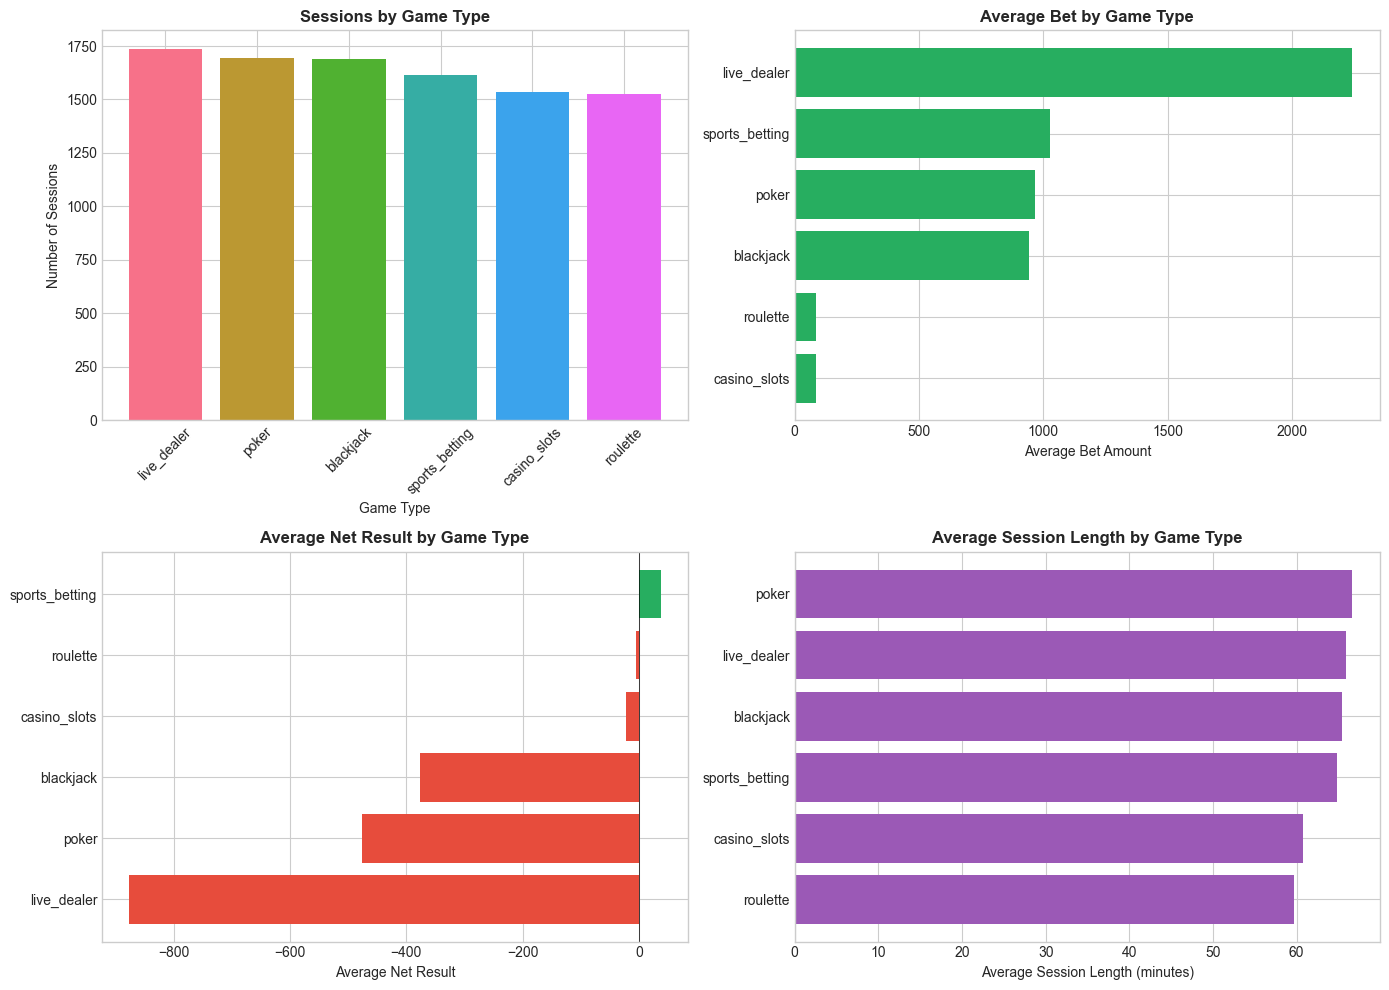

In [18]:
# Game type visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sessions by game type
game_counts = df['game_type'].value_counts()
axes[0, 0].bar(game_counts.index, game_counts.values, color=sns.color_palette('husl', len(game_counts)))
axes[0, 0].set_xlabel('Game Type')
axes[0, 0].set_ylabel('Number of Sessions')
axes[0, 0].set_title('Sessions by Game Type', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average bet by game type
avg_bet_by_game = df.groupby('game_type')['bet_amount'].mean().sort_values(ascending=True)
axes[0, 1].barh(avg_bet_by_game.index, avg_bet_by_game.values, color='#27ae60')
axes[0, 1].set_xlabel('Average Bet Amount')
axes[0, 1].set_title('Average Bet by Game Type', fontsize=12, fontweight='bold')

# Net result by game type
net_by_game = df.groupby('game_type')['net_result'].mean().sort_values(ascending=True)
colors = ['#e74c3c' if x < 0 else '#27ae60' for x in net_by_game.values]
axes[1, 0].barh(net_by_game.index, net_by_game.values, color=colors)
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Average Net Result')
axes[1, 0].set_title('Average Net Result by Game Type', fontsize=12, fontweight='bold')

# Session length by game type
session_by_game = df.groupby('game_type')['session_length_minutes'].mean().sort_values(ascending=True)
axes[1, 1].barh(session_by_game.index, session_by_game.values, color='#9b59b6')
axes[1, 1].set_xlabel('Average Session Length (minutes)')
axes[1, 1].set_title('Average Session Length by Game Type', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8. Campaign Analysis

In [ ]:
# Campaign effectiveness - merge with target
first_sessions = df_processed[df_processed['is_first_session']].copy()
first_sessions = first_sessions.merge(target.reset_index(), on='user_id')

# Churn rate by campaign type (lower is better)
campaign_churn = first_sessions.groupby('campaign_type').agg({
    'user_id': 'count',
    'churn': ['sum', 'mean']
}).round(4)

campaign_churn.columns = ['Total Users', 'Churned', 'Churn Rate']
campaign_churn['Retained'] = campaign_churn['Total Users'] - campaign_churn['Churned']
campaign_churn['Retention Rate'] = 1 - campaign_churn['Churn Rate']
campaign_churn = campaign_churn.sort_values('Churn Rate', ascending=True)  # Lower churn is better
campaign_churn['Churn Rate %'] = (campaign_churn['Churn Rate'] * 100).round(2)
campaign_churn['Retention Rate %'] = (campaign_churn['Retention Rate'] * 100).round(2)
campaign_churn

In [ ]:
# Campaign visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Users by campaign
campaign_counts = first_sessions['campaign_type'].value_counts()
axes[0].pie(campaign_counts.values, labels=campaign_counts.index, autopct='%1.1f%%',
            colors=sns.color_palette('husl', len(campaign_counts)))
axes[0].set_title('Users by First Session Campaign', fontsize=12, fontweight='bold')

# Churn rate by campaign (lower is better, so use reverse colors)
campaign_churn_sorted = campaign_churn.sort_values('Churn Rate %')
bars = axes[1].barh(campaign_churn_sorted.index, 
                    campaign_churn_sorted['Churn Rate %'],
                    color=sns.color_palette('viridis_r', len(campaign_churn_sorted)))
axes[1].axvline(target.mean() * 100, color='red', linestyle='--', 
                label=f'Overall Churn Rate: {target.mean()*100:.1f}%')
axes[1].set_xlabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by Campaign Type (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].legend()

# Add percentage labels
for bar, pct in zip(bars, campaign_churn_sorted['Churn Rate %']):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{pct:.1f}%', va='center')

plt.tight_layout()
plt.show()

---
## 9. First Session Result Analysis (KEY INSIGHT)

In [ ]:
# Analyze impact of first session result on churn
first_sessions['first_session_won'] = first_sessions['net_result'] > 0

# Churn rate by first session result (lower churn is better)
first_result_impact = first_sessions.groupby('first_session_won').agg({
    'user_id': 'count',
    'churn': ['sum', 'mean']
})

first_result_impact.columns = ['Total Users', 'Churned', 'Churn Rate']
first_result_impact.index = ['Lost (net_result <= 0)', 'Won (net_result > 0)']
first_result_impact['Retained'] = first_result_impact['Total Users'] - first_result_impact['Churned']
first_result_impact['Retention Rate'] = 1 - first_result_impact['Churn Rate']
first_result_impact['Churn Rate %'] = (first_result_impact['Churn Rate'] * 100).round(2)
first_result_impact['Retention Rate %'] = (first_result_impact['Retention Rate'] * 100).round(2)
first_result_impact

In [ ]:
# Visualize first result impact on churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn rate comparison (lower is better)
colors = ['#e74c3c', '#27ae60']  # Red for losers (higher churn), green for winners (lower churn)
bars = axes[0].bar(['Lost First Bet', 'Won First Bet'], 
                   first_result_impact['Churn Rate %'].values,
                   color=colors)
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_title('Churn Rate by First Session Result (Lower is Better)', fontsize=12, fontweight='bold')

# Add labels
for bar, pct in zip(bars, first_result_impact['Churn Rate %']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=14)

# Net result distribution by churn status
first_sessions.boxplot(column='net_result', by='churn', ax=axes[1])
axes[1].set_xlabel('Churn Status (0=Retained, 1=Churned)')
axes[1].set_ylabel('First Session Net Result')
axes[1].set_title('First Session Net Result by Churn Status', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Calculate reduction in churn
lost_churn = first_result_impact.loc['Lost (net_result <= 0)', 'Churn Rate']
won_churn = first_result_impact.loc['Won (net_result > 0)', 'Churn Rate']
churn_reduction = (lost_churn - won_churn) / lost_churn * 100

print(f"\n{'='*50}")
print(f"KEY INSIGHT: First Win Effect on Churn")
print(f"{'='*50}")
print(f"Users who WON on first bet: {won_churn:.1%} churn rate")
print(f"Users who LOST on first bet: {lost_churn:.1%} churn rate")
print(f"CHURN REDUCTION: {churn_reduction:.1f}% lower churn for winners")

---
## 10. VIP Tier Analysis

In [ ]:
# VIP tier distribution and behavior
vip_order = ['bronze', 'silver', 'gold', 'platinum', 'diamond']

# Filter valid VIP tiers
valid_vip = first_sessions[first_sessions['vip_tier'].isin(vip_order)].copy()

vip_stats = valid_vip.groupby('vip_tier').agg({
    'user_id': 'count',
    'churn': 'mean',
    'bet_amount': 'mean',
    'session_length_minutes': 'mean'
}).round(2)

vip_stats.columns = ['Users', 'Churn Rate', 'Avg Bet', 'Avg Session Length']
vip_stats = vip_stats.reindex(vip_order)
vip_stats['Retention Rate'] = 1 - vip_stats['Churn Rate']
vip_stats['Churn Rate %'] = (vip_stats['Churn Rate'] * 100).round(2)
vip_stats['Retention Rate %'] = (vip_stats['Retention Rate'] * 100).round(2)
vip_stats

In [ ]:
# VIP visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Users by VIP tier
vip_counts = valid_vip['vip_tier'].value_counts().reindex(vip_order)
axes[0].bar(vip_counts.index, vip_counts.values, 
            color=['#cd7f32', '#c0c0c0', '#ffd700', '#e5e4e2', '#b9f2ff'])
axes[0].set_xlabel('VIP Tier')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Users by VIP Tier', fontsize=12, fontweight='bold')

# Churn rate by VIP tier (lower is better)
axes[1].plot(vip_stats.index, vip_stats['Churn Rate %'], 'o-', 
             markersize=10, linewidth=2, color='#e74c3c')
axes[1].axhline(target.mean() * 100, color='gray', linestyle='--', 
                label=f'Overall Churn: {target.mean()*100:.1f}%')
axes[1].set_xlabel('VIP Tier')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by VIP Tier (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].legend()

# Average bet by VIP tier
axes[2].bar(vip_stats.index, vip_stats['Avg Bet'],
            color=['#cd7f32', '#c0c0c0', '#ffd700', '#e5e4e2', '#b9f2ff'])
axes[2].set_xlabel('VIP Tier')
axes[2].set_ylabel('Average Bet Amount')
axes[2].set_title('Average Bet by VIP Tier', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 11. Geographic Analysis

In [ ]:
# Country analysis
country_stats = first_sessions.groupby('country').agg({
    'user_id': 'count',
    'churn': 'mean',
    'bet_amount': 'mean',
    'net_result': 'mean'
}).round(2)

country_stats.columns = ['Users', 'Churn Rate', 'Avg Bet', 'Avg Net Result']
country_stats = country_stats.sort_values('Users', ascending=False)
country_stats['Retention Rate'] = 1 - country_stats['Churn Rate']
country_stats['Churn Rate %'] = (country_stats['Churn Rate'] * 100).round(2)
country_stats['Retention Rate %'] = (country_stats['Retention Rate'] * 100).round(2)
country_stats

In [ ]:
# Geographic visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Users by country
country_counts = first_sessions['country'].value_counts()
axes[0].bar(country_counts.index, country_counts.values, color='#3498db')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Users by Country', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Churn rate by country (lower is better - use green for low churn, red for high)
country_churn = country_stats.sort_values('Churn Rate %')
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(country_churn)))  # Reversed - low churn = green
axes[1].barh(country_churn.index, country_churn['Churn Rate %'], color=colors)
axes[1].axvline(target.mean() * 100, color='red', linestyle='--', 
                label=f'Overall Churn: {target.mean()*100:.1f}%')
axes[1].set_xlabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by Country (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 12. Device Analysis

In [ ]:
# Device type analysis
device_stats = first_sessions.groupby('device_type').agg({
    'user_id': 'count',
    'churn': 'mean',
    'bet_amount': 'mean',
    'session_length_minutes': 'mean'
}).round(2)

device_stats.columns = ['Users', 'Churn Rate', 'Avg Bet', 'Avg Session Length']
device_stats['Retention Rate'] = 1 - device_stats['Churn Rate']
device_stats['Churn Rate %'] = (device_stats['Churn Rate'] * 100).round(2)
device_stats['Retention Rate %'] = (device_stats['Retention Rate'] * 100).round(2)
device_stats

In [ ]:
# Device visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#3498db', '#e74c3c', '#27ae60']

# Users by device
device_counts = first_sessions['device_type'].value_counts()
axes[0].pie(device_counts.values, labels=device_counts.index, autopct='%1.1f%%',
            colors=colors, explode=(0.05, 0, 0))
axes[0].set_title('Users by Device Type', fontsize=12, fontweight='bold')

# Churn rate by device (lower is better)
bars = axes[1].bar(device_stats.index, device_stats['Churn Rate %'], color=colors)
axes[1].axhline(target.mean() * 100, color='red', linestyle='--', 
                label=f'Overall Churn: {target.mean()*100:.1f}%')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by Device (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].legend()

# Add labels
for bar, pct in zip(bars, device_stats['Churn Rate %']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', fontweight='bold')

# Session length by device
axes[2].bar(device_stats.index, device_stats['Avg Session Length'], color=colors)
axes[2].set_ylabel('Average Session Length (min)')
axes[2].set_title('Session Length by Device', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 13. Correlation Analysis

In [ ]:
# Correlation matrix for numerical features
numerical_features = ['bet_amount', 'win_amount', 'net_result', 'session_length_minutes',
                      'games_played', 'account_age_days', 'hour', 'day_of_week',
                      'is_weekend', 'is_holiday']

# Add target to first sessions for correlation
corr_df = first_sessions[numerical_features + ['churn']].copy()
correlation_matrix = corr_df.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Top correlations with target (churn)
target_correlations = correlation_matrix['churn'].drop('churn').sort_values(key=abs, ascending=False)

print("Correlations with Churn Target:")
print("="*40)
print("(Positive = higher value leads to more churn)")
print("(Negative = higher value leads to less churn)")
print("="*40)
for feature, corr in target_correlations.items():
    print(f"{feature:30} {corr:+.4f}")

---
## 14. Survival Analysis

In [ ]:
if LIFELINES_AVAILABLE:
    # Prepare survival data
    # Time to event: days until last session (or end of observation)
    # Event: churn (no redeposit) - already our target!
    
    survival_df = user_stats.copy()
    survival_df['duration'] = (survival_df['last_session'] - survival_df['first_session']).dt.days
    survival_df['event'] = survival_df['churn']  # Event = churn (1 = churned, 0 = retained)
    survival_df = survival_df[survival_df['duration'] >= 0]  # Filter valid durations
    
    # Kaplan-Meier by VIP tier
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overall survival curve
    kmf = KaplanMeierFitter()
    kmf.fit(survival_df['duration'], event_observed=survival_df['event'], label='All Users')
    kmf.plot_survival_function(ax=axes[0])
    axes[0].set_xlabel('Days Since First Session')
    axes[0].set_ylabel('Retention Probability')
    axes[0].set_title('Kaplan-Meier Survival Curve (Overall)', fontsize=12, fontweight='bold')
    
    # Survival by VIP tier
    vip_tiers = ['bronze', 'silver', 'gold', 'platinum', 'diamond']
    colors = ['#cd7f32', '#c0c0c0', '#ffd700', '#e5e4e2', '#b9f2ff']
    
    for tier, color in zip(vip_tiers, colors):
        tier_data = survival_df[survival_df['vip_tier'] == tier]
        if len(tier_data) > 10:  # Only plot if enough data
            kmf = KaplanMeierFitter()
            kmf.fit(tier_data['duration'], event_observed=tier_data['event'], label=tier)
            kmf.plot_survival_function(ax=axes[1], color=color)
    
    axes[1].set_xlabel('Days Since First Session')
    axes[1].set_ylabel('Retention Probability')
    axes[1].set_title('Survival Curves by VIP Tier', fontsize=12, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Survival analysis skipped - lifelines library not installed")
    print("Run: pip install lifelines")

---
## 15. RFM Segmentation

In [ ]:
# Calculate RFM metrics - fix timezone
reference_date = pd.to_datetime(df['date'].max())
if hasattr(reference_date, 'tzinfo') and reference_date.tzinfo is not None:
    reference_date = reference_date.replace(tzinfo=None)

rfm_df = user_stats.copy()
rfm_df['last_session'] = pd.to_datetime(rfm_df['last_session'])
if hasattr(rfm_df['last_session'].dt, 'tz') and rfm_df['last_session'].dt.tz is not None:
    rfm_df['last_session'] = rfm_df['last_session'].dt.tz_localize(None)

rfm_df['recency'] = (reference_date - rfm_df['last_session']).dt.days
rfm_df['frequency'] = rfm_df['total_sessions']
rfm_df['monetary'] = rfm_df['total_deposits']

# Create RFM scores (1-5)
rfm_df['R_score'] = pd.qcut(rfm_df['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_df['M_score'] = pd.qcut(rfm_df['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Create RFM segment
rfm_df['RFM_score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

# Segment labels
def segment_customers(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Potential Loyalists'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Need Attention'

rfm_df['segment'] = rfm_df.apply(segment_customers, axis=1)

# Segment summary with churn rate
segment_summary = rfm_df.groupby('segment').agg({
    'user_id': 'count',
    'churn': 'mean',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)

segment_summary.columns = ['Users', 'Churn Rate', 'Avg Recency', 'Avg Frequency', 'Avg Monetary']
segment_summary = segment_summary.sort_values('Users', ascending=False)
segment_summary['Users %'] = (segment_summary['Users'] / segment_summary['Users'].sum() * 100).round(1)
segment_summary['Churn Rate %'] = (segment_summary['Churn Rate'] * 100).round(2)
segment_summary['Retention Rate %'] = (100 - segment_summary['Churn Rate %']).round(2)
segment_summary

In [ ]:
# RFM Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment distribution
segment_counts = rfm_df['segment'].value_counts()
colors = sns.color_palette('husl', len(segment_counts))
axes[0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
            colors=colors)
axes[0].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')

# Churn rate by segment (lower is better)
segment_churn = segment_summary.sort_values('Churn Rate')
bars = axes[1].barh(segment_churn.index, segment_churn['Churn Rate %'],
                    color=sns.color_palette('RdYlGn_r', len(segment_churn)))  # Reversed - low churn = green
axes[1].axvline(target.mean() * 100, color='red', linestyle='--', 
                label=f'Overall Churn: {target.mean()*100:.1f}%')
axes[1].set_xlabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by Customer Segment (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 16. Key Findings Summary

In [ ]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS - KEY FINDINGS")
print("="*70)

print(f"\n1. DATASET OVERVIEW")
print(f"   - Total Sessions: {len(df):,}")
print(f"   - Unique Users: {df['user_id'].nunique():,}")
print(f"   - Average Sessions per User: {len(df)/df['user_id'].nunique():.1f}")
print(f"   - Date Range: {df['date'].min().date()} to {df['date'].max().date()}")

print(f"\n2. TARGET VARIABLE (CHURN)")
print(f"   - Churn Rate: {target.mean():.2%}")
print(f"   - Retention Rate: {1 - target.mean():.2%}")
print(f"   - Users Churned: {target.sum():,}")
print(f"   - Users Retained: {len(target) - target.sum():,}")

print(f"\n3. FIRST WIN EFFECT (KEY INSIGHT)")
won_churn = first_result_impact.loc['Won (net_result > 0)', 'Churn Rate']
lost_churn = first_result_impact.loc['Lost (net_result <= 0)', 'Churn Rate']
churn_reduction = (lost_churn - won_churn) / lost_churn * 100
print(f"   - Winners Churn Rate: {won_churn:.2%}")
print(f"   - Losers Churn Rate: {lost_churn:.2%}")
print(f"   - Churn Reduction: {churn_reduction:.1f}% lower churn for winners")

print(f"\n4. BEST PERFORMING CAMPAIGNS (Lowest Churn)")
best_campaigns = campaign_churn.head(3)
for idx, (campaign, row) in enumerate(best_campaigns.iterrows(), 1):
    print(f"   {idx}. {campaign}: {row['Churn Rate']:.2%} churn rate ({row['Retention Rate']:.2%} retention)")

print(f"\n5. GEOGRAPHIC INSIGHTS")
top_countries = country_stats.head(3)
for idx, (country, row) in enumerate(top_countries.iterrows(), 1):
    print(f"   {idx}. {country}: {row['Users']:,} users, {row['Churn Rate']:.2%} churn rate")

print(f"\n6. DEVICE INSIGHTS")
for device, row in device_stats.iterrows():
    print(f"   - {device}: {row['Users']:,} users, {row['Churn Rate']:.2%} churn rate")

print("\n" + "="*70)

---
## 17. Save Processed Data

In [ ]:
# Save user-level data for feature engineering
user_stats.to_csv('../data/user_level_data.csv', index=False)
print(f"Saved user-level data: {user_stats.shape}")
print(f"  - Target column: 'churn' (1=churned, 0=retained)")

# Save first session data
first_sessions.to_csv('../data/first_sessions_data.csv', index=False)
print(f"Saved first sessions data: {first_sessions.shape}")

# Save RFM data
rfm_df.to_csv('../data/rfm_segmentation.csv', index=False)
print(f"Saved RFM segmentation: {rfm_df.shape}")

---
## Next Steps

The next notebook (`02_feature_engineering.ipynb`) will:
1. Create advanced features based on insights from this EDA
2. Engineer first session features
3. Create behavioral aggregations
4. Build trend features
5. Handle missing values and encoding